In [63]:
import numpy as np
import pathlib
from PIL import Image
import re
import joblib
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from natsort import natsorted
from skimage import exposure

In [64]:
pop_directory = "Data/pop"
pop_00000_directory = "Data/pop_00000"
pop_drums_directory = "Data/pop+drums"
rock_directory = "Data/rock"
country_directory = "Data/country"
pop_rock_directory = "Data/pop_rock"
blues_rock_directory = "Data/blues_rock"
blues_directory = "Data/blues"

save_pop = "assembled_pop"
save_pop_00000 = "assembled_pop_00000"
save_pop_drums = "assembled_pop+drums"
save_rock = "assembled_rock"
save_country = "assembled_country"
save_pop_rock = "assembled_pop_rock"
save_blues_rock = "assembled_blues_rock"
save_blues = "assembled_blues"

filename_gen = "TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16_lrd=0.00001/TraVeLGAN-Gen.joblib"
generator = joblib.load(filename_gen)


In transform


  0%|          | 0/16400 [00:00<?, ?it/s]

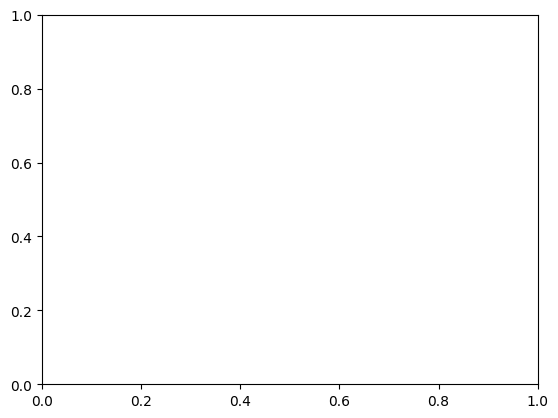

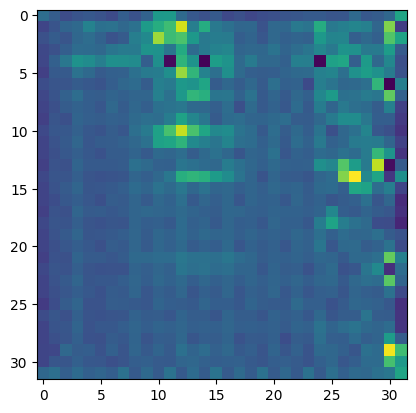

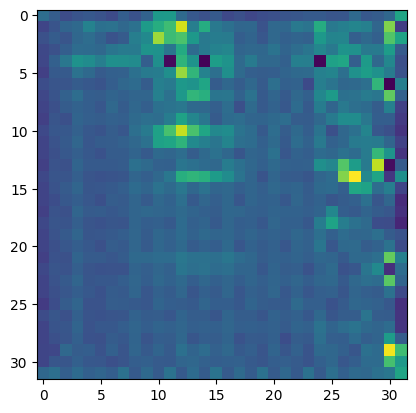

100%|██████████| 16400/16400 [00:43<00:00, 375.47it/s]


In assemble


In [65]:
def load_image(paths, index):
    image_path = paths[index]
    return Image.open(image_path)

def assemble(about, paths, save, genre):
    print("In assemble")
    for ind, i in enumerate(about):
        # assemble the i-th spectrogram
        total_width = i[0]
        s_per_line = total_width // 32
        extra = 0
        if total_width % 32 != 0:  # daca latimea nu se imparte la 32 inseamna ca mai avem o bucata incompleta la final
            extra = 1

        final_spect = Image.new('L', (total_width, 128))
        counter = i[1][0]
        for j in range(4):
            # j numara liniile
            for k in range(s_per_line):
                # k numara coloanele
                # incarcam cate o bucata si o punem pe pozitia ei
                spect = load_image(paths, counter)
                final_spect.paste(spect, (k * 32, j * 32))
                counter += 1
            if extra:
                spect = load_image(paths, counter)
                counter += 1
                remaining = total_width % 32
                spect_np = np.array(spect)
                last_columns = spect_np[:, -remaining:]
                spect = Image.fromarray(last_columns)
                final_spect.paste(spect, (total_width // 32, j * 32))

        final_spect.save(f"Data/{save}/{genre}_spec{ind}.png")
        if counter != i[1][1] : print(counter, i[1][1])


def transform_spects(paths, genre):
    print("In transform")
    for ind in tqdm(range(len(paths))):
        image = load_image(paths, ind)

        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),  # imaginile sunt normalizate intre [0, 1]
            torchvision.transforms.Normalize(0.5, 0.5),  # imaginile sunt normalizate intre [-1, 1]
        ])
        image = transform(image)

        image = torch.unsqueeze(image, 0)
        image = generator(image)

        image = torch.squeeze(image, 0)
        image = torch.squeeze(image, 0)

        new_np = image.detach().numpy().astype(np.float32)
        new_np = (new_np * 255).astype(np.uint8)

        # if ind == 0:
        #     fig, axs = plt.subplots(1)
        #     axs.imshow(new_np)
        #     plt.show()

        im = Image.fromarray(new_np)
        # if ind == 0:
        #     fig, axs = plt.subplots(1)
        #     axs.imshow(im)
        #     plt.show()

        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(f"Data/{genre}/{genre}_spec{ind}.png")


#about_pop = np.load('pop_items.npy', allow_pickle=True)
#about_pop = np.load('pop_00000.npy', allow_pickle=True)
#about_rock = np.load('rock_items.npy', allow_pickle=True)
#about_country = np.load('country_items.npy', allow_pickle=True)
about_blues = np.load('blues_items.npy', allow_pickle=True)

#pop_paths = sorted(pathlib.Path(pop_directory).glob('*.jpg'), key=lambda p: int(re.search(r'\d+', p.stem).group()))
#pop_paths = sorted(pathlib.Path(pop_00000_directory).glob('*.jpg'), key=lambda p: int(re.search(r'\d+', p.stem).group()))
#pop_paths = natsorted(pathlib.Path(pop_00000_directory).glob('*.jpg'))
#rock_paths = sorted(pathlib.Path(rock_directory).glob('*.jpg'), key=lambda p: int(re.search(r'\d+', p.stem).group()))
#country_paths = sorted(pathlib.Path(country_directory).glob('*.jpg'), key=lambda p: int(re.search(r'\d+', p.stem).group()))
blues_paths = sorted(pathlib.Path(blues_directory).glob('*.jpg'), key=lambda p: int(re.search(r'\d+', p.stem).group()))

#transform_spects(pop_paths, 'pop_rock')
transform_spects(blues_paths, 'blues_rock')
blues_paths2 = natsorted(pathlib.Path(blues_rock_directory).glob('*.png'))
#pop_paths2 = natsorted(pathlib.Path(pop_rock_directory).glob('*.png'))

#rock_pop_paths = sorted(pathlib.Path(rock_pop_directory).glob('*.jpg'), key=lambda p: int(re.search(r'\d+', p.stem).group()))

#assemble(about_pop, pop_paths, save_pop, 'pop')
#assemble(about_pop, pop_paths2, save_pop_rock, 'pop_rock')
#assemble(about_rock, rock_paths, save_rock, 'rock')
#assemble(about_country, country_paths, save_country, 'country')
#assemble(about_rock, rock_pop_paths, save_rock_pop, 'rock_pop')
#assemble(about_blues, blues_paths, save_blues, 'blues')
assemble(about_blues, blues_paths2, save_blues_rock, 'blues_rock')